In [1]:
import cv2
import time
import argparse
import numpy as np
from PIL import Image
from keras.models import model_from_json
from utils.anchor_generator import generate_anchors
from utils.anchor_decode import decode_bbox
from utils.nms import single_class_non_max_suppression
from load_model.keras_loader import load_keras_model, keras_inference
from IPython.display import display
import xml.etree.ElementTree as ET
from os import walk

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPUs


# 有戴口罩 1 沒帶 0

In [2]:
ROOT_IMAGE_PATH = 'test_image/'
ROOT_XML_PATH = 'annotation/'

In [3]:
def remove_miss_pic():
    # Remove miss pic
    img = [i.replace('.jpg','') for i in next(walk(ROOT_IMAGE_PATH))[2]]
    xml = [i.replace('.xml','') for i in next(walk(ROOT_XML_PATH))[2]]
    for i in  img:
        if i not in xml:
            os.remove(ROOT_IMAGE_PATH+i+'.jpg')

In [5]:
def init_answer() -> (list,list):
    # init label and it's filename
    ans,filename = [],[]
    for xml in next(walk(ROOT_XML_PATH))[2]:
        tree = ET.parse(ROOT_XML_PATH + xml)
        root = tree.getroot()
        temp = []
        for objects in root.findall('object'):
            if objects.find('name').text == 'face':
                temp.append(0)
            else:
                temp.append(1)
        filename.append(root.find('filename').text.replace('.jpg','').replace('.xml',''))
        ans.append(temp)
    return ans,filename

In [6]:
ANS , filename = init_answer()

In [7]:
ANS[:10]

[[1, 1, 1], [1], [0, 1], [1], [1], [1], [1], [1, 0], [1], [1]]

In [8]:
filename[:10]

['test_00000006',
 'test_00000007',
 'test_00000008',
 'test_00000009',
 'test_00000010',
 'test_00000012',
 'test_00000013',
 'test_00000014',
 'test_00000015',
 'test_00000016']

In [9]:
model = load_keras_model("models/face_mask_detection.json", "models/face_mask_detection.hdf5")
# anchor configuration
feature_map_sizes = [[33, 33], [17, 17], [9, 9], [5, 5], [3, 3]]
anchor_sizes = [[0.04, 0.056], [0.08, 0.11], [0.16, 0.22], [0.32, 0.45], [0.64, 0.72]]
anchor_ratios = [[1, 0.62, 0.42]] * 5
# generate anchors
anchors = generate_anchors(feature_map_sizes, anchor_sizes, anchor_ratios)
# for inference , the batch size is 1, the model output shape is [1, N, 4],
# so we expand dim for anchors to [1, anchor_num, 4]
anchors_exp = np.expand_dims(anchors, axis=0)
id2class = {0: "Mask", 1: "NoMask"}

In [10]:
def inference(image,conf_thresh=0.5,iou_thresh=0.4,target_shape=(160, 160),draw_result=True,show_result=True)->list:
    output_info = []
    height, width, _ = image.shape
    image_resized = cv2.resize(image, target_shape)
    image_np = image_resized / 255.0  # 歸一化到 0 ~ 1
    image_exp = np.expand_dims(image_np, axis=0)
    y_bboxes_output, y_cls_output = keras_inference(model, image_exp)
    # remove the batch dimension, for batch is always 1 for inference.
    y_bboxes = decode_bbox(anchors_exp, y_bboxes_output)[0]
    y_cls = y_cls_output[0]
    # To speed up, do single class NMS, not multiple classes NMS.
    bbox_max_scores = np.max(y_cls, axis=1)
    bbox_max_score_classes = np.argmax(y_cls, axis=1)
    # keep_idx is the alive bounding box after nms.
    keep_idxs = single_class_non_max_suppression(y_bboxes, bbox_max_scores, conf_thresh=conf_thresh, iou_thresh=iou_thresh)
    for idx in keep_idxs:
        conf = float(bbox_max_scores[idx])
        class_id = bbox_max_score_classes[idx]
        bbox = y_bboxes[idx]
        # clip the coordinate, avoid the value exceed the image boundary.
        xmin = max(0, int(bbox[0] * width))
        ymin = max(0, int(bbox[1] * height))
        xmax = min(int(bbox[2] * width), width)
        ymax = min(int(bbox[3] * height), height)
        if draw_result:
            if class_id == 0:
                color = (0, 255, 0)
            else:
                color = (255, 0, 0)
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
            cv2.putText(image,f"{id2class[class_id]}: {np.round(conf,3)}",(xmin + 2, ymin - 2),cv2.FONT_HERSHEY_SIMPLEX,0.8,color,)
        output_info.append([class_id, conf, xmin, ymin, xmax, ymax])
    if show_result:
        display(Image.fromarray(image))
        pass
    return output_info

In [11]:
def show(path,show_result = False) ->list:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return inference(img, show_result=show_result , target_shape=(260, 260))

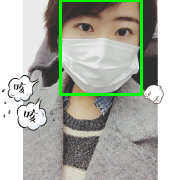

[[0, 0.9999232292175293, 60, 0, 141, 94]]

In [12]:
show(ROOT_IMAGE_PATH+'test_00000009.jpg', show_result = True)

In [13]:
All_result = []
for i,pic in enumerate(next(walk(ROOT_IMAGE_PATH))[2]):
    temp_res = []
    for res in show(ROOT_IMAGE_PATH+pic):
        temp_res.append(res[0])
    All_result.append(temp_res)
    if i%100 == 0:
        print(f"Processing ... {i}")
len(All_result)

Processing ... 0
Processing ... 100
Processing ... 200
Processing ... 300
Processing ... 400
Processing ... 500
Processing ... 600
Processing ... 700
Processing ... 800
Processing ... 900
Processing ... 1000
Processing ... 1100
Processing ... 1200
Processing ... 1300
Processing ... 1400
Processing ... 1500
Processing ... 1600
Processing ... 1700
Processing ... 1800
Processing ... 1900
Processing ... 2000
Processing ... 2100
Processing ... 2200
Processing ... 2300
Processing ... 2400
Processing ... 2500
Processing ... 2600
Processing ... 2700
Processing ... 2800
Processing ... 2900
Processing ... 3000
Processing ... 3100
Processing ... 3200
Processing ... 3300
Processing ... 3400
Processing ... 3500
Processing ... 3600
Processing ... 3700


3722

## Label
### Postive - 有戴口罩 1
### Negtive - 沒戴口罩 0

## Pred
### Postive - 有戴口罩 0
### Negtive - 沒戴口罩 1

In [14]:
FN = 0
FP = 0
TP = 0
TN = 0

error_pred = []
right_ans = []
right_ans_one_p = []
one_p = []

for i,pred in enumerate(All_result): 
    '''
    預測人數已和 label 全部一樣
    '''
    # transfer prediction 0 -> 1 , 1 -> 0
    pred = [1 - j for j in pred]
    p_mask = sum(pred)
    p_unmask = len(pred) - p_mask
    r_mask = sum(ANS[i])
    r_unmask = len(ANS[i]) - r_mask
        
    if len(ANS[i]) == len(pred) and len(ANS[i]) == 1:
        one_p.append(filename[i])
        
    if p_mask == r_mask:
        TP += r_mask
        TN += r_unmask  
        right_ans.append(filename[i])
        if len(ANS[i]) == 1:
            right_ans_one_p.append(filename[i])
        
    if p_mask > r_mask:
        FP += p_mask - r_mask
        TP += r_mask
        TN += p_unmask
        error_pred.append(filename[i])
            
    if p_mask < r_mask:
        FN += r_mask - p_mask
        TP += p_mask
        TN += r_unmask
        error_pred.append(filename[i])
        
print(f'Num of Pictures that Have Errors：{len(error_pred)}')
print(f'Num of Pictures that Predict Right：{len(right_ans)}')
print(f'Num of Pictures Prediction ACC ：{np.round(len(right_ans)/(len(right_ans)+len(error_pred)) ,3)}％')

print('\n')
print(f'Num of One Person Pictures：{len(one_p)}')
print(f'Num of One Person and Prediction Right ：{len(right_ans_one_p)}')
print(f'One Person Prediction ACC ：{np.round(len(right_ans_one_p)/len(one_p),3)}％')

Num of Pictures that Have Errors：117
Num of Pictures that Predict Right：3605
Num of Pictures Prediction ACC ：0.969％


Num of One Person Pictures：3056
Num of One Person and Prediction Right ：2984
One Person Prediction ACC ：0.976％


In [15]:
TP

3373

In [16]:
TN

1207

In [17]:
FP

32

In [18]:
FN

91

In [19]:
# TPR
TP/(TP+FN)

0.973729792147806

In [20]:
# TNR
TN/(TN+FP)

0.9741727199354318